In [1]:
import numpy as np
import scipy
from scipy.special import comb
import matplotlib.pyplot as plt

# The Cox-Ross-Rubinstein model
Computer Problem Set 1.1

Student: Nicolas MEIRA SINOTT LOPES

## Global variables

In [2]:
N = 50
SIGMA = 0.3
R = 0.05
B = 0.05
S0 = 100
T = 2

## Exercise 1

### 1.a

In [3]:
## Question 1.a

def Sn(
        T: int, 
        n: int, 
        b: float, 
        sigma: float, 
        j: int
    ) -> float:
    
    h = T/n

    u = np.e**(b * h + sigma * np.sqrt(h))
    d = np.e**(b * h - sigma * np.sqrt(h))

    pow_d = np.arange(0,j+1)
    pow_u = np.arange(j,-1,-1)

    return S0 * (u**pow_u * d**pow_d)

### 1.b

In [4]:
## Question 1.b

def Payoffn(
        T: int, 
        n: int, 
        b: float, 
        sigma: float, 
        K: float
    ) -> np.array:

    # Getting vector Sn with j = n
    Sn_vec = Sn(
        T=T, 
        n=n, 
        b=b, 
        sigma=sigma, 
        j=n
        )

    # Setting vector function of Payoff
    vfunc = np.vectorize(lambda x : max(x - K,0))
    
    return vfunc(Sn_vec)

### 1.c

In [5]:
## Question 1.c

def Calln(
    T: int, 
    n: int,
    r: float,
    b: float, 
    sigma: float, 
    K: float
    ) -> float:
    
    # Generating q
    h = T/n
    u = np.e**(b * h + sigma * np.sqrt(h))
    d = np.e**(b * h - sigma * np.sqrt(h))
    R = np.e**(r*h)

    q = (R - d) / (u - d)
    
    ## Getting probability distribution of outcomes
    # Combinatorics elements
    ks = np.arange(n+1)
    ns = n * np.ones(n+1)
    C = comb(ns, ks)

    # Probability elements
    pow_q = np.arange(n, -1, -1)
    pow_mq = np.arange(0,n+1)
    prob_ind = q**pow_q * (1-q)**pow_mq

    prob = prob_ind * C

    ## Getting the payoff
    payoff = Payoffn(
        T=T, 
        n=n, 
        b=b, 
        sigma=sigma, 
        K=K)

    price = np.e**(-r*T) * (payoff * prob).sum()

    return price

### 1.d

In [6]:
## Question 1.d

def Deltan(
        T : int, 
        n : int, 
        r : float, 
        b : float, 
        sigma : float, 
        K : float, 
        j : int
        ) -> np.array:
    
    h = T/n
    u = np.e**(b * h + sigma * np.sqrt(h))
    d = np.e**(b * h - sigma * np.sqrt(h))
    
    ## Payoff of next step
    # Getting Sn at j+1
    Sn_vec = Sn(
        T=T, 
        n=n, 
        b=b, 
        sigma=sigma, 
        j=j+1
        )
    
    vfunc = np.vectorize(lambda x : max(x - K,0))
    payoff = vfunc(Sn_vec) 

    # Adjusting to current j
    # payoff *= np.e**(-r*h)

    ## Getting current j prices
    Sn_vec = Sn(
        T=T, 
        n=n, 
        b=b, 
        sigma=sigma, 
        j=j
        )

    return (payoff[0:-1] - payoff[1:]) / (Sn_vec * (u - d))

### 1.e

#### Analysis of Calln

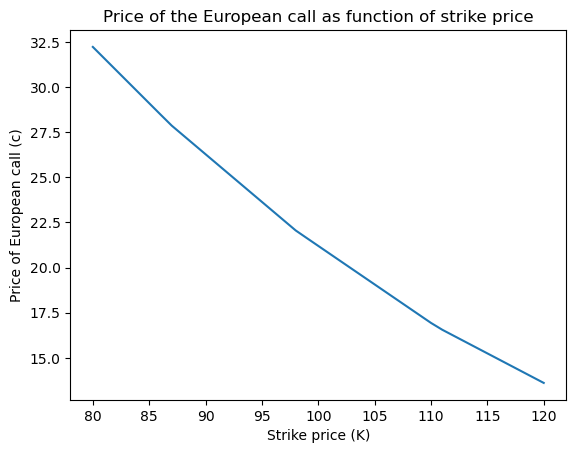

In [7]:
Ks = np.arange(80, 121)

vCalln = np.vectorize(lambda x : Calln(T, N, R, B, SIGMA,x))
Callns = vCalln(Ks)

plt.plot(Ks, Callns)
plt.title("Price of the European call as function of strike price")
plt.xlabel('Strike price (K)')
plt.ylabel('Price of European call (c)')
plt.show()

We remark from the curve that the price of the european call decreases as function of the strike price. This is rather intuitive as the payoff at $t = T$ is $max(0, S - K)$, hence the lower the strike the higher is the payoff (as long as the strike is above the spot).

#### Analisis of Deltan

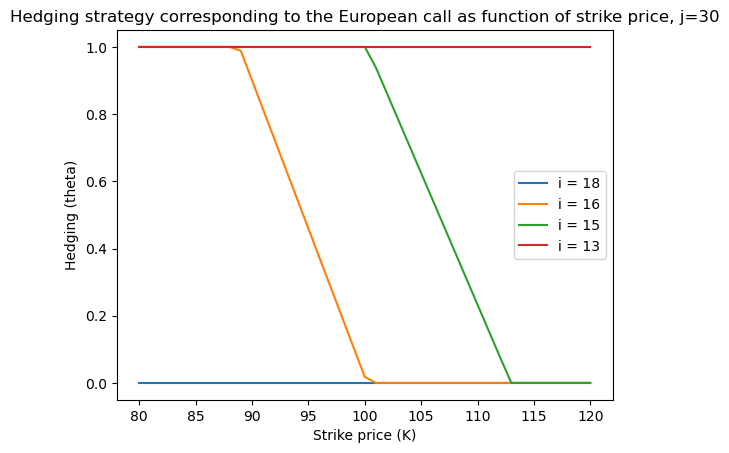

In [8]:
j = 30

vDeltan = np.vectorize(lambda x : Deltan(T, N, R, B, SIGMA, x, j)[j//2 + 3])
Deltans =  vDeltan(Ks)

vDeltan = np.vectorize(lambda x : Deltan(T, N, R, B, SIGMA, x, j)[j//2 + 1])
Deltans2 =  vDeltan(Ks)

vDeltan = np.vectorize(lambda x : Deltan(T, N, R, B, SIGMA, x, j)[j//2])
Deltans3 =  vDeltan(Ks)

vDeltan = np.vectorize(lambda x : Deltan(T, N, R, B, SIGMA, x, j)[j//2 - 2])
Deltans4 =  vDeltan(Ks)

plt.plot(Ks, Deltans)
plt.plot(Ks, Deltans2)
plt.plot(Ks, Deltans3)
plt.plot(Ks, Deltans4)

plt.legend([f'i = {j//2 + 3}', f'i = {j//2 + 1}', f'i = {j//2}', f'i = {j//2 - 2}'])
plt.title(f"Hedging strategy corresponding to the European call as function of strike price, {j=}")
plt.xlabel('Strike price (K)')
plt.ylabel('Hedging (theta)')
plt.show()

Here we can clearly see that our curve follows a straight line when the strike price of the call is in between the values $d S_{j,i}^{n}$ (down) and $uS_{j,i}^{n}$ (up) as expected by our model (cases $i = 15$ and $i = 16$).

When both the up and down prices are below $K$, they always take $\theta = 0$, which is intuitive as there is no probability the the call will be executed. On the opposite hand, if $K$ is below both up and down prices of the next step, we have $\theta  = 1$, as they would always be executed. These extremes can be respectively visualized with $i = 18$ and $i = 13$.

## Exercise 2

### 2.a

In [9]:
## Question 2.a

def Call(
        T: int, 
        r: float, 
        sigma: float, 
        K: float
        ) -> float:
    
    K_tilde = K*np.e**(-r*T)
    d_plus = np.log(S0 / K_tilde) / np.sqrt(T * sigma**2) + sigma*np.sqrt(T)/2
    d_minus = d_plus - sigma*np.sqrt(T)

    return S0 * scipy.stats.norm.cdf(d_plus) - K_tilde*scipy.stats.norm.cdf(d_minus)


### 2.b

In [10]:
## Question 2.b

def err(
        T: int, 
        n: int,
        r: float, 
        b : float, 
        sigma: float, 
        K: float
        ) -> float:
    
    return Calln(T,n,r,b,sigma,K) / Call(T,r,sigma,K) - 1

#### Analysis of err

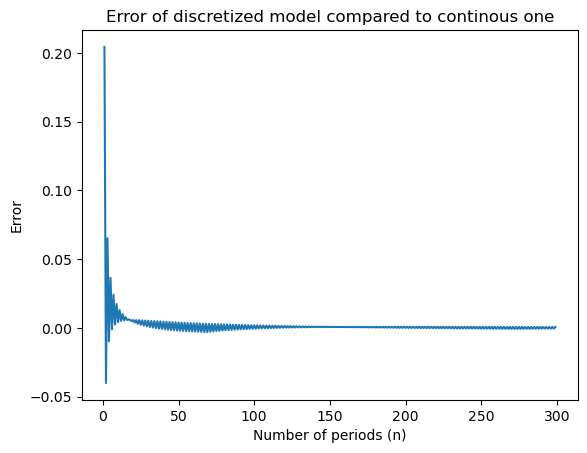

In [11]:
ns = np.arange(1, 300)
K = 105

vErr = np.vectorize(lambda x : err(T, x, R, B, SIGMA,K))
errs = vErr(ns)

plt.plot(ns, errs)
plt.title("Error of discretized model compared to continous one")
plt.xlabel('Number of periods (n)')
plt.ylabel('Error')
# plt.yscale('log')
plt.show()

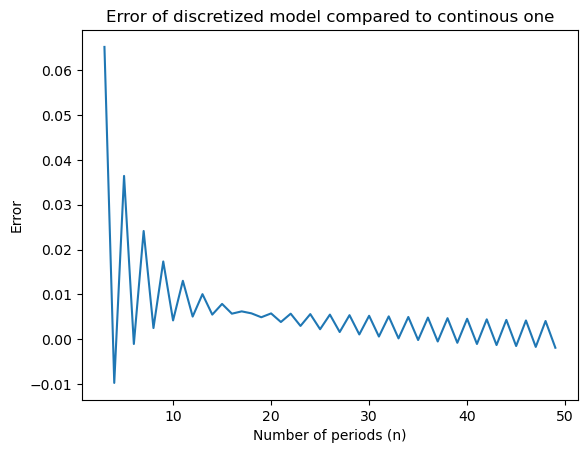

In [12]:
ns = np.arange(3, 50)
K = 105

vErr = np.vectorize(lambda x : err(T, x, R, B, SIGMA,K))
errs = vErr(ns)

plt.plot(ns, errs)
plt.title("Error of discretized model compared to continous one")
plt.xlabel('Number of periods (n)')
plt.ylabel('Error')
# plt.yscale('log')
plt.show()

We see that very quickly the discrete model converges to the continuous one. Taking $n \geq 15$ yield an error that is already below 1% in norm.